## The 2-agent multi-agent Active Blockference

In [1]:
import itertools
import numpy as np
import seaborn as sns
from pymdp import utils
from copy import deepcopy
import matplotlib.pyplot as plt

Now we define a helper plotting function

In [2]:
def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

Next we define the gridworld the agents will occupy

Position dictionary is {0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (1, 0), 4: (1, 1), 5: (1, 2), 6: (2, 0), 7: (2, 1), 8: (2, 2)}
Grid locations are [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


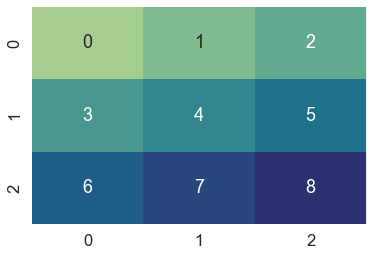

In [3]:
grid_locations = list(itertools.product(range(3), repeat=2))
num_grid_points = len(grid_locations)

pos_dict = {}
for i in range(0, len(grid_locations)):
    pos_dict[i] = grid_locations[i]
plot_grid(grid_locations)
print(f'Position dictionary is {pos_dict}')
print(f'Grid locations are {grid_locations}')

## Construct the A matrix

The A matrix represents the likelihood mapping between agents' observations and their hidden states.

In the 2 agent case, a single agents observes:
1. its current location (1 out of 9 for a 3x3 grid world)
2. the location of the other agent (1 out of 9 for a 3x3 grid world)

This means the A matrix needs to be a rank 2 tensor with each submatrix representing beliefs over a location, given an observation of my location and the observation of the other agent's location.

The number of possible locations for both agents is the same (9).

**The resulting shape of the A matrix should be (2,) with each submatrix being (9, 9, 9).**

#### States and observations in the 3x3 grid world for 2 agents

The first agent has 9 possible locations to visit in the grid world. The second agent does as well.

We will encode the number of states in a sparse representation, by modality. The first modality is the location of the agent receiving the observation, the second is the location of the other agent.

In [4]:
num_states = [len(grid_locations), len(grid_locations)]; num_states

[9, 9]

The number of observations is the same as the number of states (hidden states).

In [7]:
num_obs = [len(grid_locations), len(grid_locations)]

The shape of the A matrix is determined by the dimension of each respective modality and the number thereof.

To recap, the number of modalities is 2: The first modality is the location of the agent receiving the observation, the second is the location of the other agent.

The dimension of each modality is 9x9 (same as the grid world).

Hence, we can define the shape of the A matrix as [[9, 9], [9, 9]].

In [8]:
A_m_shapes = [[9, 9, 9], [9, 9, 9]]; A_m_shapes

[[9, 9, 9], [9, 9, 9]]

From the general shape, we construct the A matrix with the help of pymdp's `obj_array_zeros` function, which will just initialize the matrix with null entries (we'll fill in the correct entries later).

In [9]:
A = utils.obj_array_zeros(A_m_shapes); A

array([array([[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0., 0., 0.

For instance, `A[0][3,1,4]` encodes the likelihood of seeing myself in location 3, given that I am in location 1 and my neighbour is in location 4.

For the fully observable case, the indexes `A[0][n, n, m]` where n != m is 1, all other indexes are 0.
Equivalently, we have `A[1][n, m, n] = 1` for n != m.

In [10]:
# # for A[0]
# for i in range(0, 9):
#     for j in range(0, 9):
#         if i != j:
#             A[0][i, i, j] = 1 / 8

# # for A[1]
# for i in range(0, 9):
#     for j in range(0, 9):
#         if i != j:
#             A[1][i, j, i] = 1.0

# To avoid pymdp normalization error, NOTE: This does not encode the fact that the agents cannot collide.
# for A[0]
for i in range(0, 9):
    for j in range(0, 9):
        A[0][i, i, j] = 1.0

# for A[1]
for i in range(0, 9):
    for j in range(0, 9):
        A[1][i, j, i] = 1.0

In [11]:
A

array([array([[[1., 1., 1., 1., 1., 1., 1., 1., 1.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [1., 1., 1., 1., 1., 1., 1., 1., 1.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0., 0., 0.

## Construct the B matrix

The B matrix should look exactly the same as in the single-agent case, because the position of the other agent, while an observation encoded in the A matrix, is not a controllable modality, hence there is no representation of its transition dynamics in the B matrix.

In [12]:
B_m_shapes = [[9, 9, 5], [9, 9, 1]]; B_m_shapes

[[9, 9, 5], [9, 9, 1]]

In [13]:
B = utils.obj_array_zeros(B_m_shapes); B

array([array([[[0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.

In [14]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

for action_id, action_label in enumerate(actions):

    for curr_state, grid_location in enumerate(grid_locations):

      y, x = grid_location

      if action_label == "UP":
        next_y = y - 1 if y > 0 else y 
        next_x = x
      elif action_label == "DOWN":
        next_y = y + 1 if y < 2 else y 
        next_x = x
      elif action_label == "LEFT":
        next_x = x - 1 if x > 0 else x 
        next_y = y
      elif action_label == "RIGHT":
        next_x = x + 1 if x < 2 else x 
        next_y = y
      elif action_label == "STAY":
        next_x = x
        next_y = y
      new_location = (next_y, next_x)
      next_state = grid_locations.index(new_location)
      B[0][next_state, curr_state, action_id] = 1.0

In [15]:
for i in range(0, 9):
    B[1][i, i] = 1.0
print(B[1].sum(axis=0))

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [16]:
B.shape

(2,)

In [17]:
B

array([array([[[1., 0., 1., 0., 1.],
               [0., 0., 1., 0., 0.],
               [0., 0., 0., 0., 0.],
               [1., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.]],

              [[0., 0., 0., 1., 0.],
               [1., 0., 0., 0., 1.],
               [0., 0., 1., 0., 0.],
               [0., 0., 0., 0., 0.],
               [1., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0.],
               [0., 0., 0., 1., 0.],
               [1., 0., 0., 1., 1.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [1., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.

## Construct the C matrix

C encodes the preferred state of the agent, i.e. the location the agent is trying to reach.

This is where we need to consider the two C matrices for the individual agents, since they're going to differ from each other depending on the preferred location they're trying to reach.

In this case of a 3x3 grid world, let's say the first agent wants to reach location (2, 2), i.e. location 8 (Note: the starting index is 0), and the second agent wants to reach location (1, 0), i.e. location 3 in the above visualization.

We encode the C matrix as a one-hot vector, where 1 is placed at the index of the preferred location (0s otherwise).

Note: we also define a helper function for creating a flat distribution denoting no preference over the second observation modality (i.e. the state of the *other* agent). Later, we're going to use the pymdp `Agent` class which requires the shape of C to match the number of observation modalities.

In [18]:
def create_flat_dist(num_values):
    arr = np.zeros(num_values)
    for i, _ in enumerate(arr):
        arr[i] = 1.0 / num_values
    return arr

We define the shape of the C matrix in the same way we did the A matrix.

In [19]:
C_m_shapes = [[9], [9]]

In [20]:
C = utils.obj_array_zeros(C_m_shapes); C

array([array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0., 0., 0., 0., 0.])], dtype=object)

In [21]:
agent1_C = deepcopy(C)

In [22]:
agent1_C[0] = utils.onehot(8, num_grid_points); agent1_C[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [23]:
agent1_C[1] = create_flat_dist(num_grid_points); agent1_C[1]

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111])

In [24]:
print(f'Agent 1 C matrix: {agent1_C}')

Agent 1 C matrix: [array([0., 0., 0., 0., 0., 0., 0., 0., 1.])
 array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11111111])           ]


Now we define the second agent's C matrix in an equivalent way.

In [25]:
agent2_C = deepcopy(C)
agent2_C[0] = utils.onehot(3, num_grid_points)
agent2_C[1] = create_flat_dist(num_grid_points)

print(f'Agent 2 C matrix: {agent2_C}')

Agent 2 C matrix: [array([0., 0., 0., 1., 0., 0., 0., 0., 0.])
 array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11111111])           ]


## Construct the D matrix

The D matrix encodes the prior belief about where the state of the grid world, including the position of the first agent and the second agent. Much like the C matrix, we need to create 2 such objects for each of the agents.

Let's say the first agent starts in location (0, 0), index 0, and the second in location (2, 1), index 7.

In [30]:
agent1_D = utils.obj_array(2)

agent1_D[0] = utils.onehot(0, 9)
agent1_D[1] = utils.onehot(7, 9)
print(f'Agent 1 D matrix: {agent1_D}')

agent2_D = utils.obj_array(2)

agent2_D[0] = utils.onehot(7, 9)
agent2_D[1] = utils.onehot(0, 9)
print(f'Agent 2 D matrix: {agent2_D}')

Agent 1 D matrix: [array([1., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 1., 0.])]
Agent 2 D matrix: [array([0., 0., 0., 0., 0., 0., 0., 1., 0.])
 array([1., 0., 0., 0., 0., 0., 0., 0., 0.])]


## Construct the E matrix

We've already defined the E matrix when we were initializing the B matrix, it only consists of the actions available to the agents.

The E vector is in terms of policies, not actions, so its size will depend on the length of planning we want the agent to undertake.

In [31]:
from pymdp.control import construct_policies

In [32]:
E_1 = construct_policies(num_states, num_controls=[5, 1], policy_len=1)
print(f'Length of E_1 is {len(E_1)}')
E_2 = construct_policies(num_states, num_controls=[5, 1], policy_len=2)
print(f'Length of E_2 is {len(E_2)}')
E_3 = construct_policies(num_states, num_controls=[5, 1], policy_len=3)
print(f'Length of E_3 is {len(E_3)}')
E_4 = construct_policies(num_states, num_controls=[5, 1], policy_len=4)
print(f'Length of E_4 is {len(E_4)}')

Length of E_1 is 5
Length of E_2 is 25
Length of E_3 is 125
Length of E_4 is 625


## Construct the two Agents

Now that we've defined all the components for our two agents, initializing them is taken care of by the pymdp `Agent` class.

In [33]:
from pymdp.agent import Agent

In [37]:
agent1 = Agent(A=deepcopy(A), B=deepcopy(B), C=agent1_C, D=agent1_D, E=np.array(deepcopy(E_4)), policy_len=4)
agent2 = Agent(A=deepcopy(A), B=deepcopy(B), C=agent2_C, D=agent2_D, E=np.array(deepcopy(E_4)), policy_len=4)

## Prepare cadCAD simulation